## Mapping and appending dataset with GoEmotions

In [24]:
from datasets import load_dataset
goemo = load_dataset("go_emotions", "simplified")
print(goemo)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [29]:
emotion_to_value = {
    "admiration": "Achievement attained",
    "approval": "Conformity: rules attained",
    "gratitude": "Benevolence: caring attained",
    "love": "Benevolence: dependability attained",
    "caring": "Benevolence: caring attained",
    "optimism": "Stimulation attained",
    "joy": "Hedonism attained",
    "excitement": "Stimulation attained",
    "curiosity": "Self-direction: thought attained",
    "desire": "Self-direction: action attained",
    "amusement": "Hedonism attained",
    "pride": "Power: dominance attained",
    "relief": "Security: personal attained",

    "fear": "Security: personal constrained",
    "nervousness": "Security: societal constrained",
    "remorse": "Humility constrained",
    "embarrassment": "Face constrained",
    "disappointment": "Achievement constrained",
    "disapproval": "Conformity: interpersonal constrained",
    "anger": "Power: dominance constrained",
    "annoyance": "Conformity: rules constrained",
    "confusion": "Self-direction: thought constrained",
    "grief": "Universalism: concern constrained",
    "sadness": "Benevolence: caring constrained",
    "neutral": None,  # drop neutral (no clear mapping)
    "realization": "Self-direction: thought attained"
}

In [31]:
VALUES_19 = [
    "Self-direction: thought",
    "Self-direction: action",
    "Stimulation",
    "Hedonism",
    "Achievement",
    "Power: dominance",
    "Power: resources",
    "Face",
    "Security: personal",
    "Security: societal",
    "Tradition",
    "Conformity: rules",
    "Conformity: interpersonal",
    "Humility",
    "Benevolence: caring",
    "Benevolence: dependability",
    "Universalism: concern",
    "Universalism: nature",
    "Universalism: tolerance",
]

VALUE_COLUMNS = [f"{v} attained" for v in VALUES_19] + [f"{v} constrained" for v in VALUES_19]

In [33]:
def map_emotions(example):
    mapped = []
    for emo_id in example["labels"]:
        emo_name = label_names[emo_id]
        if emo_name in emotion_to_value and emotion_to_value[emo_name] is not None:
            mapped.append(emotion_to_value[emo_name])
    return {"value_labels": mapped}

In [35]:
goemo_mapped = goemo.map(map_emotions)

In [37]:
def to_multihot(batch):
    mh = {v: [0] * len(batch["text"]) for v in VALUE_COLUMNS}
    for i, labs in enumerate(batch["value_labels"]):
        for lab in labs:
            if lab in mh: 
                mh[lab][i] = 1
    mh["text"] = batch["text"]
    return mh

goemo_mh = goemo_mapped.map(to_multihot, batched=True, batch_size=1000)

In [39]:
train_df = pd.DataFrame(goemo_mh["train"])
val_df = pd.DataFrame(goemo_mh["validation"])
test_df = pd.DataFrame(goemo_mh["test"])

In [41]:
print(train_df.head(3))
print("Columns:", train_df.columns.tolist())

                                                text labels       id  \
0  My favourite food is anything I didn't have to...   [27]  eebbqej   
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i   
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj   

                     value_labels  Self-direction: thought attained  \
0                              []                                 0   
1                              []                                 0   
2  [Power: dominance constrained]                                 0   

   Self-direction: action attained  Stimulation attained  Hedonism attained  \
0                                0                     0                  0   
1                                0                     0                  0   
2                                0                     0                  0   

   Achievement attained  Power: dominance attained  ...  \
0                     0                          0

## Appending

In [46]:
import pandas as pd

hv_labels = pd.read_csv("training-english/labels_training.tsv", sep="\t")
hv_sentences = pd.read_csv("training-english/sentences_training.tsv", sep="\t")

hv_df = pd.merge(hv_labels, hv_sentences, on=["Text-ID", "Sentence-ID"])

hv_df = hv_df.rename(columns={"Text": "text"})
hv_df = hv_df[["text"] + [c for c in hv_df.columns if c not in ["Text-ID", "Sentence-ID", "text"]]]

In [58]:
combined_train = pd.concat([hv_df, train_df], ignore_index=True)

print("Original HV size:", hv_df.shape)
print("GoEmotions mapped size:", train_df.shape)
print("Combined size:", combined_train.shape)


Original HV size: (44758, 39)
GoEmotions mapped size: (43410, 42)
Combined size: (88168, 42)


Target per label: 398

Counts after balancing:
 Humility attained                          75
Tradition constrained                      85
Hedonism constrained                      107
Stimulation constrained                   126
Benevolence: dependability constrained    180
Universalism: tolerance attained          216
Universalism: tolerance constrained       237
Universalism: nature constrained          237
Conformity: interpersonal attained        248
Self-direction: action constrained        261
Humility constrained                      288
Self-direction: thought constrained       353
Benevolence: caring constrained           358
Security: personal attained               367
Face attained                             380
Face constrained                          390
Hedonism attained                         393
Power: dominance constrained              396
Conformity: interpersonal constrained     396
Tradition attained                        397
Security: personal constrained  

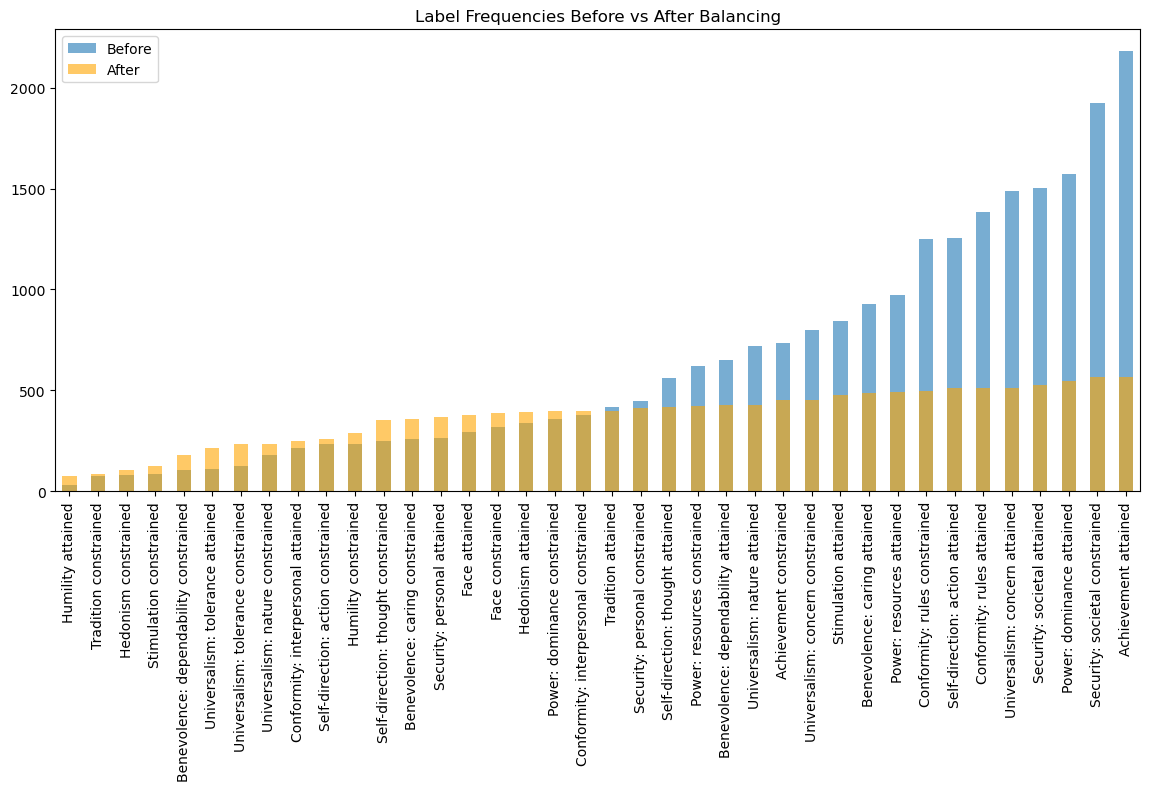

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


hv_labels = pd.read_csv("training-english/labels_training.tsv", sep="\t")
hv_sentences = pd.read_csv("training-english/sentences_training.tsv", sep="\t")

hv_df = pd.merge(hv_labels, hv_sentences, on=["Text-ID", "Sentence-ID"])
hv_df = hv_df.rename(columns={"Text": "text"})

label_cols = [c for c in hv_df.columns if c not in ["Text-ID", "Sentence-ID", "text"]]
hv_df = hv_df[["text"] + label_cols]


hv_df[label_cols] = hv_df[label_cols].astype(int)

train_df = train_df[["text"] + label_cols]
train_df[label_cols] = train_df[label_cols].astype(int)


def balance_dataset(hv_df, goemo_df, label_cols, strategy="median"):
    
    hv_counts = hv_df[label_cols].sum()

    if strategy == "median":
        target = int(hv_counts.median())
    elif strategy == "mean":
        target = int(hv_counts.mean())
    elif strategy == "percentile90":
        target = int(np.percentile(hv_counts.values, 90))
    else:
        raise ValueError("Invalid strategy. Use 'median', 'mean', or 'percentile90'.")

    print("Target per label:", target)


    oversampled = []
    for label in label_cols:
        deficit = target - hv_counts[label]
        if deficit > 0:
            candidates = goemo_df[goemo_df[label] == 1]
            if not candidates.empty:
                sampled = candidates.sample(
                    n=min(int(deficit), len(candidates)),
                    replace=True,  
                    random_state=42
                )
                oversampled.append(sampled)

    goemo_balanced = pd.concat(oversampled, ignore_index=True) if oversampled else pd.DataFrame(columns=hv_df.columns)


    combined = pd.concat([hv_df, goemo_balanced], ignore_index=True)


    final_parts = []
    for label in label_cols:
        positives = combined[combined[label] == 1]
        if len(positives) > target:
            positives = positives.sample(n=target, random_state=42)
        final_parts.append(positives)


    balanced = pd.concat(final_parts, ignore_index=True).drop_duplicates()


    new_counts = balanced[label_cols].sum().sort_values()
    print("\nCounts after balancing:\n", new_counts)

    return balanced

balanced_df = balance_dataset(hv_df, train_df, label_cols, strategy="median")


balanced_df.to_csv("balanced_training.csv", index=False)

before = hv_df[label_cols].sum().sort_values()
after = balanced_df[label_cols].sum().sort_values()

plt.figure(figsize=(14,6))
before.plot(kind="bar", alpha=0.6, label="Before")
after.plot(kind="bar", alpha=0.6, label="After", color="orange")
plt.legend()
plt.title("Label Frequencies Before vs After Balancing")
plt.show()
